
**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 22 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 50      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 40       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [ ]:
# Clone github repository with data
if not os.path.isdir('./CancerDataset'):
  !git clone https://github.com/zainkhan-afk/CancerDataset.git

DATA_DIR = 'CancerDataset/Dataset'

# Prepare Pytorch train/test Datasets
train_dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=eval_transform)

train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
test_indexes = [idx for idx in range(len(test_dataset)) if not idx % 5]

train_dataset = Subset(train_dataset, train_indexes)
test_dataset = Subset(test_dataset, test_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Cloning into 'CancerDataset'...
remote: Enumerating objects: 43450, done.
remote: Total 43450 (delta 0), reused 0 (delta 0), pack-reused 43450
Receiving objects: 100% (43450/43450), 591.84 MiB | 46.30 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (48524/48524), done.
Train Dataset: 38819
Test Dataset: 9705


**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [ ]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

lossVec = []
accVec = []

lowestLoss = 1000
modelSaveDir = '/content/model'
modelName = '/bestModel'

if not os.path.isdir(modelSaveDir):
  os.mkdir(modelSaveDir)

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    if loss<lowestLoss:
      lowestLoss = loss
      torch.save(net, modelSaveDir + modelName)
      # print("Model Saved")

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataset))

  print('Test Accuracy: {}'.format(accuracy))
  accVec.append(accuracy) 
  lossVec.append(lowestLoss)
  # Step the scheduler
  scheduler.step() 

Starting epoch 1/50, LR = [0.01]
Step 0, Loss 3.091320037841797
Step 10, Loss 3.08178973197937
Step 20, Loss 3.0690643787384033
Step 30, Loss 3.0478060245513916
Step 40, Loss 3.039980411529541
Step 50, Loss 2.9958109855651855
Step 60, Loss 2.991184711456299
Step 70, Loss 2.9114668369293213
Step 80, Loss 2.911703109741211
Step 90, Loss 2.904829740524292
Step 100, Loss 2.952801465988159
Step 110, Loss 2.9080255031585693
Step 120, Loss 2.906795024871826
Step 130, Loss 2.8804519176483154
Step 140, Loss 2.890775203704834


  0%|          | 0/38 [00:00<?, ?it/s]

Step 150, Loss 2.8772897720336914


100%|██████████| 38/38 [00:21<00:00,  2.79it/s]

Test Accuracy: 0.09397217928902628
Starting epoch 2/50, LR = [0.01]


Step 160, Loss 2.8537509441375732
Step 170, Loss 2.8199305534362793
Step 180, Loss 2.7553648948669434
Step 190, Loss 2.5095527172088623
Step 200, Loss 2.442066192626953
Step 210, Loss 2.2616360187530518
Step 220, Loss 2.2418713569641113
Step 230, Loss 2.194263458251953
Step 240, Loss 2.3289973735809326
Step 250, Loss 2.2226693630218506
Step 260, Loss 2.330397605895996
Step 270, Loss 2.230647325515747
Step 280, Loss 2.168099880218506
Step 290, Loss 2.1352930068969727
Step 300, Loss 2.1611850261688232


100%|██████████| 38/38 [00:23<00:00,  2.94it/s]

Test Accuracy: 0.25244719216898504
Starting epoch 3/50, LR = [0.01]


Step 310, Loss 2.1193013191223145
Step 320, Loss 2.1137514114379883
Step 330, Loss 2.057454824447632
Step 340, Loss 2.040879249572754
Step 350, Loss 2.0743408203125
Step 360, Loss 2.0635039806365967
Step 370, Loss 2.1411876678466797
Step 380, Loss 2.0166945457458496
Step 390, Loss 1.8719786405563354
Step 400, Loss 1.8533716201782227
Step 410, Loss 1.8223880529403687
Step 420, Loss 1.7904231548309326
Step 430, Loss 1.8508206605911255
Step 440, Loss 1.5979210138320923
Step 450, Loss 1.5826369524002075


100%|██████████| 38/38 [00:23<00:00,  2.76it/s]

Test Accuracy: 0.4051519835136528
Starting epoch 4/50, LR = [0.01]


Step 460, Loss 1.6024748086929321
Step 470, Loss 1.5822525024414062
Step 480, Loss 1.5266956090927124
Step 490, Loss 1.4648282527923584
Step 500, Loss 1.5738155841827393
Step 510, Loss 1.5190974473953247
Step 520, Loss 1.398268222808838
Step 530, Loss 1.3466907739639282
Step 540, Loss 1.295742392539978
Step 550, Loss 1.2320029735565186
Step 560, Loss 1.305355191230774
Step 570, Loss 1.372541069984436
Step 580, Loss 2.043041467666626
Step 590, Loss 2.0841221809387207
Step 600, Loss 1.5183780193328857


100%|██████████| 38/38 [00:23<00:00,  3.04it/s]

Test Accuracy: 0.45275631117980425
Starting epoch 5/50, LR = [0.01]


Step 610, Loss 1.4142534732818604
Step 620, Loss 1.2723510265350342
Step 630, Loss 1.151943564414978
Step 640, Loss 1.108790397644043
Step 650, Loss 1.2318800687789917
Step 660, Loss 1.3013168573379517
Step 670, Loss 1.2769567966461182
Step 680, Loss 1.3563835620880127
Step 690, Loss 1.108372688293457
Step 700, Loss 1.1182914972305298
Step 710, Loss 1.074555516242981
Step 720, Loss 1.1462279558181763
Step 730, Loss 1.569526195526123
Step 740, Loss 1.3881165981292725
Step 750, Loss 1.421079158782959


100%|██████████| 38/38 [00:24<00:00,  3.05it/s]

Test Accuracy: 0.5689850592478104
Starting epoch 6/50, LR = [0.01]


Step 760, Loss 1.1346378326416016
Step 770, Loss 1.0775991678237915
Step 780, Loss 0.9799559712409973
Step 790, Loss 0.9941952228546143
Step 800, Loss 1.0477807521820068
Step 810, Loss 0.8877713084220886
Step 820, Loss 0.9873955845832825
Step 830, Loss 0.926699697971344
Step 840, Loss 0.7828435897827148
Step 850, Loss 0.8359473347663879
Step 860, Loss 1.0194728374481201
Step 870, Loss 1.1681206226348877
Step 880, Loss 0.9107504487037659
Step 890, Loss 0.8469670414924622
Step 900, Loss 0.9975027441978455


100%|██████████| 38/38 [00:22<00:00,  3.01it/s]

Test Accuracy: 0.635342606903658
Starting epoch 7/50, LR = [0.01]


Step 910, Loss 0.9251003861427307
Step 920, Loss 0.7448908090591431
Step 930, Loss 0.6594604253768921
Step 940, Loss 0.713503897190094
Step 950, Loss 0.9133076667785645
Step 960, Loss 0.729862630367279
Step 970, Loss 0.7477402687072754
Step 980, Loss 0.6842073798179626
Step 990, Loss 0.7177872657775879
Step 1000, Loss 0.9920376539230347
Step 1010, Loss 0.7489113807678223
Step 1020, Loss 0.958733081817627
Step 1030, Loss 0.842147171497345
Step 1040, Loss 0.6487128734588623
Step 1050, Loss 0.6555545926094055


100%|██████████| 38/38 [00:24<00:00,  2.55it/s]

Test Accuracy: 0.7336424523441525
Starting epoch 8/50, LR = [0.01]


Step 1060, Loss 0.7460591197013855
Step 1070, Loss 0.6028082966804504
Step 1080, Loss 0.7633169889450073
Step 1090, Loss 2.026447057723999
Step 1100, Loss 1.549429178237915
Step 1110, Loss 1.3102599382400513
Step 1120, Loss 1.1431238651275635
Step 1130, Loss 0.8797774910926819
Step 1140, Loss 1.1977583169937134
Step 1150, Loss 1.0872273445129395
Step 1160, Loss 0.8841811418533325
Step 1170, Loss 0.8265912532806396
Step 1180, Loss 0.9429364204406738
Step 1190, Loss 0.9021116495132446
Step 1200, Loss 0.6507604718208313


100%|██████████| 38/38 [00:24<00:00,  2.78it/s]

Test Accuracy: 0.7171561051004637
Starting epoch 9/50, LR = [0.01]


Step 1210, Loss 0.7035043239593506
Step 1220, Loss 0.6784441471099854
Step 1230, Loss 0.6707884073257446
Step 1240, Loss 0.6595526337623596
Step 1250, Loss 0.6392583847045898
Step 1260, Loss 0.5533451437950134
Step 1270, Loss 0.8113279938697815
Step 1280, Loss 0.568958044052124
Step 1290, Loss 0.5707979798316956
Step 1300, Loss 0.6950943470001221
Step 1310, Loss 0.5844439268112183
Step 1320, Loss 0.6698378324508667
Step 1330, Loss 0.5297828912734985
Step 1340, Loss 0.5091875791549683
Step 1350, Loss 0.6935264468193054


100%|██████████| 38/38 [00:23<00:00,  3.33it/s]

Test Accuracy: 0.758887171561051
Starting epoch 10/50, LR = [0.01]


Step 1360, Loss 0.4403861165046692
Step 1370, Loss 0.5426526069641113
Step 1380, Loss 0.6688056588172913
Step 1390, Loss 0.6134107112884521
Step 1400, Loss 0.5683691501617432
Step 1410, Loss 0.644106924533844
Step 1420, Loss 0.4921872019767761
Step 1430, Loss 0.5227940082550049
Step 1440, Loss 0.6312524080276489
Step 1450, Loss 0.5631188154220581
Step 1460, Loss 0.5735353231430054
Step 1470, Loss 0.6377771496772766
Step 1480, Loss 0.679412305355072
Step 1490, Loss 0.45630520582199097
Step 1500, Loss 0.5406063199043274


100%|██████████| 38/38 [00:24<00:00,  2.57it/s]

Test Accuracy: 0.7714580113343638
Starting epoch 11/50, LR = [0.01]


Step 1510, Loss 0.460125207901001
Step 1520, Loss 0.5648453235626221
Step 1530, Loss 0.5942883491516113
Step 1540, Loss 0.4370933473110199
Step 1550, Loss 0.41805315017700195
Step 1560, Loss 0.40310126543045044
Step 1570, Loss 0.41488128900527954
Step 1580, Loss 0.4046432673931122
Step 1590, Loss 0.5465918779373169
Step 1600, Loss 0.4431673288345337
Step 1610, Loss 0.45060813426971436
Step 1620, Loss 0.4577910304069519
Step 1630, Loss 0.5089858174324036
Step 1640, Loss 0.4391378164291382
Step 1650, Loss 0.36523446440696716


  0%|          | 0/38 [00:00<?, ?it/s]

Step 1660, Loss 0.36737486720085144


100%|██████████| 38/38 [00:24<00:00,  2.63it/s]

Test Accuracy: 0.7884595569294178
Starting epoch 12/50, LR = [0.01]


Step 1670, Loss 0.5695595741271973
Step 1680, Loss 0.38484692573547363
Step 1690, Loss 0.3675142526626587
Step 1700, Loss 0.38852164149284363
Step 1710, Loss 0.5194651484489441
Step 1720, Loss 0.6066380143165588
Step 1730, Loss 0.526864767074585
Step 1740, Loss 0.4697609841823578
Step 1750, Loss 0.3986482620239258
Step 1760, Loss 0.47501009702682495
Step 1770, Loss 0.4868943691253662
Step 1780, Loss 0.548305332660675
Step 1790, Loss 0.43911340832710266
Step 1800, Loss 0.4240131974220276
Step 1810, Loss 0.4164290726184845


100%|██████████| 38/38 [00:23<00:00,  2.69it/s]

Test Accuracy: 0.7958784131890778
Starting epoch 13/50, LR = [0.01]


Step 1820, Loss 0.45227038860321045
Step 1830, Loss 0.3704133629798889
Step 1840, Loss 0.6188207864761353
Step 1850, Loss 0.4461113214492798
Step 1860, Loss 0.44665250182151794
Step 1870, Loss 0.4100528061389923
Step 1880, Loss 0.3960533142089844
Step 1890, Loss 0.4116153120994568
Step 1900, Loss 0.3834664523601532
Step 1910, Loss 0.352711021900177
Step 1920, Loss 0.3813888430595398
Step 1930, Loss 0.4113645553588867
Step 1940, Loss 0.4431644380092621
Step 1950, Loss 0.3308959901332855
Step 1960, Loss 0.3030022084712982


100%|██████████| 38/38 [00:23<00:00,  3.23it/s]

Test Accuracy: 0.8150437918598661
Starting epoch 14/50, LR = [0.01]


Step 1970, Loss 0.30559712648391724
Step 1980, Loss 0.35103073716163635
Step 1990, Loss 0.3904062509536743
Step 2000, Loss 0.32832610607147217
Step 2010, Loss 0.34582996368408203
Step 2020, Loss 0.3384563624858856
Step 2030, Loss 0.40470483899116516
Step 2040, Loss 0.3498642146587372
Step 2050, Loss 0.34153681993484497
Step 2060, Loss 0.41352248191833496
Step 2070, Loss 0.3573334813117981
Step 2080, Loss 0.40664806962013245
Step 2090, Loss 0.30312180519104004
Step 2100, Loss 0.3085741400718689
Step 2110, Loss 0.4603031277656555


100%|██████████| 38/38 [00:23<00:00,  3.00it/s]

Test Accuracy: 0.7912416280267903
Starting epoch 15/50, LR = [0.01]


Step 2120, Loss 0.313255250453949
Step 2130, Loss 0.3757612705230713
Step 2140, Loss 0.37537863850593567
Step 2150, Loss 0.2768113613128662
Step 2160, Loss 0.3346564471721649
Step 2170, Loss 0.39030563831329346
Step 2180, Loss 0.39846259355545044
Step 2190, Loss 0.4766644537448883
Step 2200, Loss 0.5091742873191833
Step 2210, Loss 0.42143550515174866
Step 2220, Loss 0.38304463028907776
Step 2230, Loss 0.7156854271888733
Step 2240, Loss 0.45110034942626953
Step 2250, Loss 0.33478283882141113
Step 2260, Loss 0.4723169505596161


100%|██████████| 38/38 [00:24<00:00,  2.71it/s]

Test Accuracy: 0.8150437918598661
Starting epoch 16/50, LR = [0.01]


Step 2270, Loss 0.398284375667572
Step 2280, Loss 0.358258455991745
Step 2290, Loss 0.4364941120147705
Step 2300, Loss 0.4112924337387085
Step 2310, Loss 0.26904258131980896
Step 2320, Loss 0.3355511724948883
Step 2330, Loss 0.27088838815689087
Step 2340, Loss 0.21349376440048218
Step 2350, Loss 0.31621211767196655
Step 2360, Loss 0.2961971163749695
Step 2370, Loss 0.38627004623413086
Step 2380, Loss 0.4076410233974457
Step 2390, Loss 0.37285757064819336
Step 2400, Loss 0.36724627017974854
Step 2410, Loss 0.3157273828983307


100%|██████████| 38/38 [00:23<00:00,  2.72it/s]

Test Accuracy: 0.850386398763524
Starting epoch 17/50, LR = [0.01]


Step 2420, Loss 0.32762613892555237
Step 2430, Loss 0.25863224267959595
Step 2440, Loss 0.34147533774375916
Step 2450, Loss 0.31140080094337463
Step 2460, Loss 0.3245059847831726
Step 2470, Loss 0.36506325006484985
Step 2480, Loss 0.23644202947616577
Step 2490, Loss 0.3365556597709656
Step 2500, Loss 0.28218257427215576
Step 2510, Loss 0.25563159584999084
Step 2520, Loss 0.3537691831588745
Step 2530, Loss 0.31931349635124207
Step 2540, Loss 0.2987799048423767
Step 2550, Loss 0.27190691232681274
Step 2560, Loss 0.2396181970834732


100%|██████████| 38/38 [00:23<00:00,  2.62it/s]

Test Accuracy: 0.8514167954662545
Starting epoch 18/50, LR = [0.01]


Step 2570, Loss 0.2561454474925995
Step 2580, Loss 0.3506163954734802
Step 2590, Loss 0.24987922608852386
Step 2600, Loss 0.2341478317975998
Step 2610, Loss 0.290284126996994
Step 2620, Loss 0.3051544725894928
Step 2630, Loss 0.2943096160888672
Step 2640, Loss 0.28460371494293213
Step 2650, Loss 0.28612053394317627
Step 2660, Loss 0.2458159476518631
Step 2670, Loss 0.5091933012008667
Step 2680, Loss 0.3667365610599518
Step 2690, Loss 0.29663193225860596
Step 2700, Loss 0.3026268482208252
Step 2710, Loss 0.26521241664886475


100%|██████████| 38/38 [00:23<00:00,  2.84it/s]

Test Accuracy: 0.8361669242658424
Starting epoch 19/50, LR = [0.01]


Step 2720, Loss 0.27337658405303955
Step 2730, Loss 0.3049233555793762
Step 2740, Loss 0.22587740421295166
Step 2750, Loss 0.2592301368713379
Step 2760, Loss 0.2627401351928711
Step 2770, Loss 0.26936671137809753
Step 2780, Loss 0.24572709202766418
Step 2790, Loss 0.22715409100055695
Step 2800, Loss 0.20084437727928162
Step 2810, Loss 0.27804914116859436
Step 2820, Loss 0.2651199698448181
Step 2830, Loss 0.2938884496688843
Step 2840, Loss 0.373138964176178
Step 2850, Loss 0.25971719622612
Step 2860, Loss 0.2742953300476074


100%|██████████| 38/38 [00:24<00:00,  3.22it/s]

Test Accuracy: 0.8396702730551262
Starting epoch 20/50, LR = [0.01]


Step 2870, Loss 0.3070056140422821
Step 2880, Loss 0.2989318072795868
Step 2890, Loss 0.23337575793266296
Step 2900, Loss 0.3010003864765167
Step 2910, Loss 0.24286291003227234
Step 2920, Loss 0.31231093406677246
Step 2930, Loss 0.3278752267360687
Step 2940, Loss 0.229027658700943
Step 2950, Loss 0.3280375003814697
Step 2960, Loss 0.2494349181652069
Step 2970, Loss 0.24309056997299194
Step 2980, Loss 0.23133817315101624
Step 2990, Loss 0.22725920379161835
Step 3000, Loss 0.25016018748283386
Step 3010, Loss 0.22955049574375153


100%|██████████| 38/38 [00:23<00:00,  3.19it/s]

Test Accuracy: 0.8539927872230809
Starting epoch 21/50, LR = [0.01]


Step 3020, Loss 0.25599363446235657
Step 3030, Loss 0.27193883061408997
Step 3040, Loss 0.3006761372089386
Step 3050, Loss 0.3017222583293915
Step 3060, Loss 0.22848030924797058
Step 3070, Loss 0.2431405484676361
Step 3080, Loss 0.23689188063144684
Step 3090, Loss 0.30462050437927246
Step 3100, Loss 0.2324426770210266
Step 3110, Loss 0.29773226380348206
Step 3120, Loss 0.39109566807746887
Step 3130, Loss 0.25526463985443115
Step 3140, Loss 0.3082469403743744
Step 3150, Loss 0.23747271299362183
Step 3160, Loss 0.2708199620246887


  0%|          | 0/38 [00:00<?, ?it/s]

Step 3170, Loss 0.24791936576366425


100%|██████████| 38/38 [00:23<00:00,  2.73it/s]

Test Accuracy: 0.8543019062339
Starting epoch 22/50, LR = [0.01]


Step 3180, Loss 0.20652402937412262
Step 3190, Loss 0.3370601534843445
Step 3200, Loss 0.25514206290245056
Step 3210, Loss 0.21465152502059937
Step 3220, Loss 0.42480117082595825
Step 3230, Loss 0.3652726709842682
Step 3240, Loss 0.35508424043655396
Step 3250, Loss 0.2376869171857834
Step 3260, Loss 0.2526063323020935
Step 3270, Loss 0.2516883909702301
Step 3280, Loss 0.21370302140712738
Step 3290, Loss 0.23079216480255127
Step 3300, Loss 0.2543623149394989
Step 3310, Loss 0.2420809417963028
Step 3320, Loss 0.18295040726661682


100%|██████████| 38/38 [00:23<00:00,  3.00it/s]

Test Accuracy: 0.8543019062339
Starting epoch 23/50, LR = [0.01]


Step 3330, Loss 0.21556632220745087
Step 3340, Loss 0.35896703600883484
Step 3350, Loss 0.2620989978313446
Step 3360, Loss 0.27821463346481323
Step 3370, Loss 0.2947992980480194
Step 3380, Loss 0.2536125183105469
Step 3390, Loss 0.2644542455673218
Step 3400, Loss 0.3390602469444275
Step 3410, Loss 0.2621268630027771
Step 3420, Loss 0.26698923110961914
Step 3430, Loss 0.20464856922626495
Step 3440, Loss 0.24571596086025238
Step 3450, Loss 0.25039514899253845
Step 3460, Loss 0.3523029088973999
Step 3470, Loss 0.29649534821510315


100%|██████████| 38/38 [00:23<00:00,  2.79it/s]

Test Accuracy: 0.8205048943843379
Starting epoch 24/50, LR = [0.01]


Step 3480, Loss 0.24683287739753723
Step 3490, Loss 0.27516916394233704
Step 3500, Loss 0.3124748766422272
Step 3510, Loss 0.2579162120819092
Step 3520, Loss 0.2893369197845459
Step 3530, Loss 0.2377724051475525
Step 3540, Loss 0.24375945329666138
Step 3550, Loss 0.17972174286842346
Step 3560, Loss 0.17833027243614197
Step 3570, Loss 0.19583234190940857
Step 3580, Loss 0.21800854802131653
Step 3590, Loss 0.2546502351760864
Step 3600, Loss 0.22205021977424622
Step 3610, Loss 0.19969066977500916
Step 3620, Loss 0.19703492522239685


100%|██████████| 38/38 [00:23<00:00,  2.84it/s]

Test Accuracy: 0.8574961360123647
Starting epoch 25/50, LR = [0.01]


Step 3630, Loss 0.20337069034576416
Step 3640, Loss 0.18514715135097504
Step 3650, Loss 0.21015936136245728
Step 3660, Loss 0.2887023389339447
Step 3670, Loss 0.24021941423416138
Step 3680, Loss 0.24056380987167358
Step 3690, Loss 0.18517479300498962
Step 3700, Loss 0.337159663438797
Step 3710, Loss 0.24284961819648743
Step 3720, Loss 0.1804012805223465
Step 3730, Loss 0.22886016964912415
Step 3740, Loss 0.26255905628204346
Step 3750, Loss 0.2644861340522766
Step 3760, Loss 0.2981194853782654
Step 3770, Loss 0.2571157217025757


100%|██████████| 38/38 [00:23<00:00,  2.94it/s]

Test Accuracy: 0.8570839773312725
Starting epoch 26/50, LR = [0.01]


Step 3780, Loss 0.18925003707408905
Step 3790, Loss 0.2617547810077667
Step 3800, Loss 0.20339477062225342
Step 3810, Loss 0.19185200333595276
Step 3820, Loss 0.17062948644161224
Step 3830, Loss 0.25515955686569214
Step 3840, Loss 0.20412683486938477
Step 3850, Loss 0.18697898089885712
Step 3860, Loss 0.22352735698223114
Step 3870, Loss 0.25936996936798096
Step 3880, Loss 0.186386376619339
Step 3890, Loss 0.19475865364074707
Step 3900, Loss 0.19117796421051025
Step 3910, Loss 0.20852816104888916
Step 3920, Loss 0.21185415983200073


100%|██████████| 38/38 [00:23<00:00,  2.95it/s]

Test Accuracy: 0.8472952086553323
Starting epoch 27/50, LR = [0.01]


Step 3930, Loss 0.24093611538410187
Step 3940, Loss 0.2522818148136139
Step 3950, Loss 0.18114988505840302
Step 3960, Loss 0.2280072420835495
Step 3970, Loss 0.22312888503074646
Step 3980, Loss 0.22842296957969666
Step 3990, Loss 0.2023579627275467
Step 4000, Loss 0.15718084573745728
Step 4010, Loss 0.26473331451416016
Step 4020, Loss 0.17464838922023773
Step 4030, Loss 0.2309444546699524
Step 4040, Loss 0.1932247132062912
Step 4050, Loss 0.19388185441493988
Step 4060, Loss 0.23157519102096558
Step 4070, Loss 0.19616174697875977


100%|██████████| 38/38 [00:23<00:00,  2.74it/s]

Test Accuracy: 0.8603812467800103
Starting epoch 28/50, LR = [0.01]


Step 4080, Loss 0.19937598705291748
Step 4090, Loss 0.14614637196063995
Step 4100, Loss 0.18397179245948792
Step 4110, Loss 0.20977987349033356
Step 4120, Loss 0.23887504637241364
Step 4130, Loss 0.20845018327236176
Step 4140, Loss 0.21690979599952698
Step 4150, Loss 0.25390392541885376
Step 4160, Loss 0.19789867103099823
Step 4170, Loss 0.18705597519874573
Step 4180, Loss 0.16849932074546814
Step 4190, Loss 0.2016044557094574
Step 4200, Loss 0.2074192762374878
Step 4210, Loss 0.17151638865470886
Step 4220, Loss 0.17802947759628296


100%|██████████| 38/38 [00:24<00:00,  2.78it/s]

Test Accuracy: 0.8607934054611025
Starting epoch 29/50, LR = [0.01]


Step 4230, Loss 0.2142753154039383
Step 4240, Loss 0.20169377326965332
Step 4250, Loss 0.18465521931648254
Step 4260, Loss 0.19165657460689545
Step 4270, Loss 0.17757870256900787
Step 4280, Loss 0.20293490588665009
Step 4290, Loss 0.21669822931289673
Step 4300, Loss 0.1916317343711853
Step 4310, Loss 0.1984059065580368
Step 4320, Loss 0.21354809403419495
Step 4330, Loss 0.17446368932724
Step 4340, Loss 0.1944151073694229
Step 4350, Loss 0.28952261805534363
Step 4360, Loss 0.24121087789535522
Step 4370, Loss 0.20363843441009521


100%|██████████| 38/38 [00:23<00:00,  2.82it/s]

Test Accuracy: 0.8489438433797012
Starting epoch 30/50, LR = [0.01]


Step 4380, Loss 0.2395622432231903
Step 4390, Loss 0.15138772130012512
Step 4400, Loss 0.16243885457515717
Step 4410, Loss 0.19975082576274872
Step 4420, Loss 0.16272175312042236
Step 4430, Loss 0.20393188297748566
Step 4440, Loss 0.16580358147621155
Step 4450, Loss 0.174989253282547
Step 4460, Loss 0.22144725918769836
Step 4470, Loss 0.2233482003211975
Step 4480, Loss 0.17940972745418549
Step 4490, Loss 0.16144904494285583
Step 4500, Loss 0.2536330223083496
Step 4510, Loss 0.18859797716140747
Step 4520, Loss 0.16794177889823914


100%|██████████| 38/38 [00:23<00:00,  2.95it/s]

Test Accuracy: 0.8609994848016487
Starting epoch 31/50, LR = [0.01]


Step 4530, Loss 0.19519498944282532
Step 4540, Loss 0.16468091309070587
Step 4550, Loss 0.19349724054336548
Step 4560, Loss 0.22831276059150696
Step 4570, Loss 0.13568054139614105
Step 4580, Loss 0.17339327931404114
Step 4590, Loss 0.1953451931476593
Step 4600, Loss 0.26072970032691956
Step 4610, Loss 0.2131011188030243
Step 4620, Loss 0.15314361453056335
Step 4630, Loss 0.2240614891052246
Step 4640, Loss 0.14802733063697815
Step 4650, Loss 0.21361935138702393
Step 4660, Loss 0.14357444643974304
Step 4670, Loss 0.16797670722007751


  0%|          | 0/38 [00:00<?, ?it/s]

Step 4680, Loss 0.18051116168498993


100%|██████████| 38/38 [00:23<00:00,  2.87it/s]

Test Accuracy: 0.8706852138073158
Starting epoch 32/50, LR = [0.01]


Step 4690, Loss 0.185613751411438
Step 4700, Loss 0.1553390920162201
Step 4710, Loss 0.16600443422794342
Step 4720, Loss 0.21465882658958435
Step 4730, Loss 0.21309781074523926
Step 4740, Loss 0.20671643316745758
Step 4750, Loss 0.15414303541183472
Step 4760, Loss 0.20690511167049408
Step 4770, Loss 0.1793612539768219
Step 4780, Loss 0.25746265053749084
Step 4790, Loss 0.17468738555908203
Step 4800, Loss 0.16491562128067017
Step 4810, Loss 0.2388724684715271
Step 4820, Loss 0.3119261860847473
Step 4830, Loss 0.23924657702445984


100%|██████████| 38/38 [00:24<00:00,  2.80it/s]

Test Accuracy: 0.8660484286450283
Starting epoch 33/50, LR = [0.01]


Step 4840, Loss 0.2381356954574585
Step 4850, Loss 0.21720492839813232
Step 4860, Loss 0.20446129143238068
Step 4870, Loss 0.22288432717323303
Step 4880, Loss 0.16274720430374146
Step 4890, Loss 0.20402449369430542
Step 4900, Loss 0.1576349437236786
Step 4910, Loss 0.15539336204528809
Step 4920, Loss 0.17538435757160187
Step 4930, Loss 0.19392290711402893
Step 4940, Loss 0.19560857117176056
Step 4950, Loss 0.20979148149490356
Step 4960, Loss 0.18910714983940125
Step 4970, Loss 0.18212316930294037
Step 4980, Loss 0.19213463366031647


100%|██████████| 38/38 [00:25<00:00,  2.50it/s]

Test Accuracy: 0.8533745492014425
Starting epoch 34/50, LR = [0.01]


Step 4990, Loss 0.23073330521583557
Step 5000, Loss 0.23041005432605743
Step 5010, Loss 0.1815243512392044
Step 5020, Loss 0.17393329739570618
Step 5030, Loss 0.2205415517091751
Step 5040, Loss 0.1632358282804489
Step 5050, Loss 0.1632959544658661
Step 5060, Loss 0.18306967616081238
Step 5070, Loss 0.24108484387397766
Step 5080, Loss 0.20404089987277985
Step 5090, Loss 0.17166733741760254
Step 5100, Loss 0.20035572350025177
Step 5110, Loss 0.18276405334472656
Step 5120, Loss 0.18137426674365997
Step 5130, Loss 0.19544607400894165


100%|██████████| 38/38 [00:24<00:00,  2.72it/s]

Test Accuracy: 0.8646058732612055
Starting epoch 35/50, LR = [0.01]


Step 5140, Loss 0.18692809343338013
Step 5150, Loss 0.14465391635894775
Step 5160, Loss 0.19122594594955444
Step 5170, Loss 0.1617565155029297
Step 5180, Loss 0.1932569146156311
Step 5190, Loss 0.16220787167549133
Step 5200, Loss 0.15613630414009094
Step 5210, Loss 0.1631140261888504
Step 5220, Loss 0.16773928701877594
Step 5230, Loss 0.1490473747253418
Step 5240, Loss 0.19610530138015747
Step 5250, Loss 0.14644378423690796
Step 5260, Loss 0.17404165863990784
Step 5270, Loss 0.20960243046283722
Step 5280, Loss 0.16779015958309174


100%|██████████| 38/38 [00:22<00:00,  3.53it/s]

Test Accuracy: 0.872952086553323
Starting epoch 36/50, LR = [0.01]


Step 5290, Loss 0.13231982290744781
Step 5300, Loss 0.1855691820383072
Step 5310, Loss 0.2015092968940735
Step 5320, Loss 0.14331313967704773
Step 5330, Loss 0.1670924872159958
Step 5340, Loss 0.20448005199432373
Step 5350, Loss 0.1806635558605194
Step 5360, Loss 0.17232435941696167
Step 5370, Loss 0.16833028197288513
Step 5380, Loss 0.22511163353919983
Step 5390, Loss 0.1171906441450119
Step 5400, Loss 0.15964555740356445
Step 5410, Loss 0.20388957858085632
Step 5420, Loss 0.18218421936035156
Step 5430, Loss 0.1879497468471527


100%|██████████| 38/38 [00:23<00:00,  2.95it/s]

Test Accuracy: 0.8502833590932509
Starting epoch 37/50, LR = [0.01]


Step 5440, Loss 0.22996507585048676
Step 5450, Loss 0.2043752819299698
Step 5460, Loss 0.2070656716823578
Step 5470, Loss 0.24134643375873566
Step 5480, Loss 0.18220238387584686
Step 5490, Loss 0.26210957765579224
Step 5500, Loss 0.14693856239318848
Step 5510, Loss 0.19369149208068848
Step 5520, Loss 0.18624626100063324
Step 5530, Loss 0.160136878490448
Step 5540, Loss 0.13631442189216614
Step 5550, Loss 0.1829492300748825
Step 5560, Loss 0.14991170167922974
Step 5570, Loss 0.14076822996139526
Step 5580, Loss 0.16342543065547943


100%|██████████| 38/38 [00:24<00:00,  2.76it/s]

Test Accuracy: 0.873055126223596
Starting epoch 38/50, LR = [0.01]


Step 5590, Loss 0.1787022054195404
Step 5600, Loss 0.1801229864358902
Step 5610, Loss 0.16974768042564392
Step 5620, Loss 0.14625641703605652
Step 5630, Loss 0.2112027406692505
Step 5640, Loss 0.18419837951660156
Step 5650, Loss 0.17895753681659698
Step 5660, Loss 0.1693972945213318
Step 5670, Loss 0.18396949768066406
Step 5680, Loss 0.17176300287246704
Step 5690, Loss 0.16323493421077728
Step 5700, Loss 0.15195521712303162
Step 5710, Loss 0.18237249553203583
Step 5720, Loss 0.1666429340839386
Step 5730, Loss 0.19386239349842072


100%|██████████| 38/38 [00:24<00:00,  2.63it/s]

Test Accuracy: 0.86543019062339
Starting epoch 39/50, LR = [0.01]


Step 5740, Loss 0.18225952982902527
Step 5750, Loss 0.15377020835876465
Step 5760, Loss 0.17645728588104248
Step 5770, Loss 0.22830559313297272
Step 5780, Loss 0.2022297978401184
Step 5790, Loss 0.17856374382972717
Step 5800, Loss 0.159489244222641
Step 5810, Loss 0.1783876270055771
Step 5820, Loss 0.16104614734649658
Step 5830, Loss 0.17627975344657898
Step 5840, Loss 0.19341826438903809
Step 5850, Loss 0.158335879445076
Step 5860, Loss 0.1775970309972763
Step 5870, Loss 0.15998531877994537
Step 5880, Loss 0.18493850529193878


100%|██████████| 38/38 [00:24<00:00,  2.70it/s]

Test Accuracy: 0.871097372488408
Starting epoch 40/50, LR = [0.01]


Step 5890, Loss 0.1888773888349533
Step 5900, Loss 0.15133827924728394
Step 5910, Loss 0.1699996143579483
Step 5920, Loss 0.12577290832996368
Step 5930, Loss 0.12995105981826782
Step 5940, Loss 0.14723853766918182
Step 5950, Loss 0.1922863870859146
Step 5960, Loss 0.15651944279670715
Step 5970, Loss 0.20264065265655518
Step 5980, Loss 0.18415936827659607
Step 5990, Loss 0.18003565073013306
Step 6000, Loss 0.18136022984981537
Step 6010, Loss 0.160667285323143
Step 6020, Loss 0.1727091372013092
Step 6030, Loss 0.1593889743089676


100%|██████████| 38/38 [00:24<00:00,  2.90it/s]

Test Accuracy: 0.8737764039155075
Starting epoch 41/50, LR = [0.0001]


Step 6040, Loss 0.16935595870018005
Step 6050, Loss 0.15864092111587524
Step 6060, Loss 0.18766669929027557
Step 6070, Loss 0.14201956987380981
Step 6080, Loss 0.13835158944129944
Step 6090, Loss 0.17745959758758545
Step 6100, Loss 0.14034709334373474
Step 6110, Loss 0.1561354547739029
Step 6120, Loss 0.1507740616798401
Step 6130, Loss 0.18125104904174805
Step 6140, Loss 0.13179969787597656
Step 6150, Loss 0.11280929297208786
Step 6160, Loss 0.15697643160820007
Step 6170, Loss 0.15814724564552307
Step 6180, Loss 0.15329647064208984


  0%|          | 0/38 [00:00<?, ?it/s]

Step 6190, Loss 0.170210599899292


100%|██████████| 38/38 [00:24<00:00,  2.76it/s]

Test Accuracy: 0.8639876352395672
Starting epoch 42/50, LR = [0.001]


Step 6200, Loss 0.16336819529533386
Step 6210, Loss 0.1691506803035736
Step 6220, Loss 0.12663817405700684
Step 6230, Loss 0.13966277241706848
Step 6240, Loss 0.14045915007591248
Step 6250, Loss 0.16256031394004822
Step 6260, Loss 0.13073259592056274
Step 6270, Loss 0.15890257060527802
Step 6280, Loss 0.14585697650909424
Step 6290, Loss 0.1181805431842804
Step 6300, Loss 0.16273579001426697
Step 6310, Loss 0.14841210842132568
Step 6320, Loss 0.14527803659439087
Step 6330, Loss 0.16676491498947144
Step 6340, Loss 0.1498296558856964


100%|██████████| 38/38 [00:24<00:00,  3.14it/s]

Test Accuracy: 0.8731581658938692
Starting epoch 43/50, LR = [0.001]


Step 6350, Loss 0.15939074754714966
Step 6360, Loss 0.17242084443569183
Step 6370, Loss 0.137490376830101
Step 6380, Loss 0.13349977135658264
Step 6390, Loss 0.17576679587364197
Step 6400, Loss 0.16686013340950012
Step 6410, Loss 0.124366395175457
Step 6420, Loss 0.18042810261249542
Step 6430, Loss 0.133658766746521
Step 6440, Loss 0.16135461628437042
Step 6450, Loss 0.1298600137233734
Step 6460, Loss 0.15422369539737701
Step 6470, Loss 0.18222874402999878
Step 6480, Loss 0.1552281379699707
Step 6490, Loss 0.14405308663845062


100%|██████████| 38/38 [00:24<00:00,  3.05it/s]

Test Accuracy: 0.8651210716125708
Starting epoch 44/50, LR = [0.001]


Step 6500, Loss 0.15632757544517517
Step 6510, Loss 0.1224944144487381
Step 6520, Loss 0.17113706469535828
Step 6530, Loss 0.15529555082321167
Step 6540, Loss 0.1104850023984909
Step 6550, Loss 0.1454557478427887
Step 6560, Loss 0.1515495926141739
Step 6570, Loss 0.12960617244243622
Step 6580, Loss 0.1843002438545227
Step 6590, Loss 0.18814095854759216
Step 6600, Loss 0.12428209185600281
Step 6610, Loss 0.1761482208967209
Step 6620, Loss 0.13998088240623474
Step 6630, Loss 0.10680779814720154
Step 6640, Loss 0.12327639758586884


100%|██████████| 38/38 [00:24<00:00,  2.85it/s]

Test Accuracy: 0.8630602782071097
Starting epoch 45/50, LR = [0.001]


Step 6650, Loss 0.12497058510780334
Step 6660, Loss 0.12929987907409668
Step 6670, Loss 0.15363778173923492
Step 6680, Loss 0.19918286800384521
Step 6690, Loss 0.16954706609249115
Step 6700, Loss 0.1815909743309021
Step 6710, Loss 0.16018930077552795
Step 6720, Loss 0.18141502141952515
Step 6730, Loss 0.16841323673725128
Step 6740, Loss 0.16441218554973602
Step 6750, Loss 0.15634983777999878
Step 6760, Loss 0.11851777136325836
Step 6770, Loss 0.14560481905937195
Step 6780, Loss 0.15344488620758057
Step 6790, Loss 0.1435243785381317


100%|██████████| 38/38 [00:24<00:00,  2.73it/s]

Test Accuracy: 0.8758371973209685
Starting epoch 46/50, LR = [0.001]


Step 6800, Loss 0.1451512575149536
Step 6810, Loss 0.17557919025421143
Step 6820, Loss 0.11626866459846497
Step 6830, Loss 0.12414218485355377
Step 6840, Loss 0.1575237661600113
Step 6850, Loss 0.13957303762435913
Step 6860, Loss 0.16335147619247437
Step 6870, Loss 0.14336618781089783
Step 6880, Loss 0.1470736861228943
Step 6890, Loss 0.1437060683965683
Step 6900, Loss 0.115738146007061
Step 6910, Loss 0.12033519148826599
Step 6920, Loss 0.14045843482017517
Step 6930, Loss 0.17446833848953247
Step 6940, Loss 0.1357145607471466


100%|██████████| 38/38 [00:24<00:00,  2.70it/s]

Test Accuracy: 0.8637815558990212
Starting epoch 47/50, LR = [0.001]


Step 6950, Loss 0.15296150743961334
Step 6960, Loss 0.16136398911476135
Step 6970, Loss 0.13329924643039703
Step 6980, Loss 0.1325654834508896
Step 6990, Loss 0.16402435302734375
Step 7000, Loss 0.1311940997838974
Step 7010, Loss 0.15105408430099487
Step 7020, Loss 0.17489297688007355
Step 7030, Loss 0.14232003688812256
Step 7040, Loss 0.164371058344841
Step 7050, Loss 0.13539183139801025
Step 7060, Loss 0.12313878536224365
Step 7070, Loss 0.13059577345848083
Step 7080, Loss 0.1502278745174408
Step 7090, Loss 0.1399068832397461


100%|██████████| 38/38 [00:23<00:00,  2.77it/s]

Test Accuracy: 0.8731581658938692
Starting epoch 48/50, LR = [0.001]


Step 7100, Loss 0.14542542397975922
Step 7110, Loss 0.13944199681282043
Step 7120, Loss 0.14323097467422485
Step 7130, Loss 0.17332948744297028
Step 7140, Loss 0.14766338467597961
Step 7150, Loss 0.14350607991218567
Step 7160, Loss 0.1740993857383728
Step 7170, Loss 0.15696565806865692
Step 7180, Loss 0.12687861919403076
Step 7190, Loss 0.13683807849884033
Step 7200, Loss 0.1639314591884613
Step 7210, Loss 0.1303463578224182
Step 7220, Loss 0.15903878211975098
Step 7230, Loss 0.16933980584144592
Step 7240, Loss 0.14594405889511108


100%|██████████| 38/38 [00:24<00:00,  2.63it/s]

Test Accuracy: 0.8738794435857805
Starting epoch 49/50, LR = [0.001]


Step 7250, Loss 0.13278080523014069
Step 7260, Loss 0.162591814994812
Step 7270, Loss 0.14945663511753082
Step 7280, Loss 0.14771431684494019
Step 7290, Loss 0.1468762755393982
Step 7300, Loss 0.14799124002456665
Step 7310, Loss 0.1772785782814026
Step 7320, Loss 0.17306986451148987
Step 7330, Loss 0.13309162855148315
Step 7340, Loss 0.16062279045581818
Step 7350, Loss 0.16262003779411316
Step 7360, Loss 0.14910845458507538
Step 7370, Loss 0.15124325454235077
Step 7380, Loss 0.14887845516204834
Step 7390, Loss 0.14537370204925537


100%|██████████| 38/38 [00:23<00:00,  3.13it/s]

Test Accuracy: 0.8775888717156105
Starting epoch 50/50, LR = [0.001]


Step 7400, Loss 0.15963846445083618
Step 7410, Loss 0.14590366184711456
Step 7420, Loss 0.15464256703853607
Step 7430, Loss 0.13462239503860474
Step 7440, Loss 0.16183996200561523
Step 7450, Loss 0.14723540842533112
Step 7460, Loss 0.14855408668518066
Step 7470, Loss 0.17302541434764862
Step 7480, Loss 0.15159396827220917
Step 7490, Loss 0.137086421251297
Step 7500, Loss 0.14375250041484833
Step 7510, Loss 0.16086632013320923
Step 7520, Loss 0.16076886653900146
Step 7530, Loss 0.15506169199943542
Step 7540, Loss 0.16948243975639343


100%|██████████| 38/38 [00:23<00:00,  2.72it/s]

Test Accuracy: 0.870994332818135


**Test**

In [ ]:
net = torch.load(modelSaveDir + modelName)
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 38/38 [00:24<00:00,  2.88it/s]

Test Accuracy: 0.869242658423493


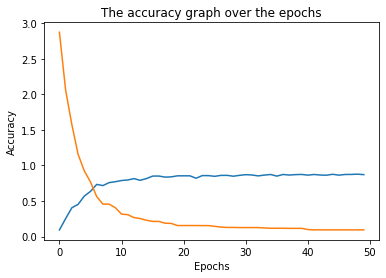

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accVec)
plt.plot(lossVec)
plt.title("The accuracy graph over the epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# print(test_dataloader.dataset.dataset.classes)

['Bladder', 'Cervics', 'HeadNeck', 'Kidney', 'Lung', 'Ovary', 'Pancreas', 'Prostate', 'Sarcoma', 'Skin', 'Uterus']
